In [7]:
import pandas as pd
import pyvo
import os
import requests
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm
import argparse
import sys
import datetime

def logd(msg):
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"[{now}] {msg}")

def read_eso_credentials(env_file):
    # First, try environment variables
    logd("Checking ESO credentials in environment variables ...")
    user = os.environ.get("ESO_USERNAME")
    pw = os.environ.get("ESO_PASSWORD")

    if user and pw:
        logd("ESO credentials found in environment variables.")
        return user, pw

    # If not found, try eso.env file
    logd(f"ESO credentials not found in environment. Trying env file: {env_file}")
    if os.path.exists(env_file):
        creds = {}
        logd(f"Found {env_file}. Reading credentials ...")
        with open(env_file) as f:
            for line in f:
                if "=" in line:
                    k, v = line.strip().split("=", 1)
                    creds[k.strip()] = v.strip()
        user = creds.get("ESO_USERNAME")
        pw = creds.get("ESO_PASSWORD")
        if user and pw:
            logd("ESO credentials successfully read from env file.")
            return user, pw

    logd("ESO credentials not found. Cannot proceed.")
    raise EnvironmentError(
        "Please set ESO_USERNAME and ESO_PASSWORDs environment variables "
        "or provide them in an eso.env file for authentication."
    )

def download_data(instrument, target, output_dir, USER, PASS):
    logd(f"Starting download_data for instrument='{instrument}', target='{target}', output_dir='{output_dir}'")

    tap_url = "https://archive.eso.org/tap_obs"
    logd(f"Initializing TAP service at {tap_url}")
    tap = pyvo.dal.TAPService(tap_url)

    import re
    def safe_str(s):
        return re.sub(r"[^a-zA-Z0-9_\- ]", "", str(s))

    safe_instrument = safe_str(instrument)
    safe_target = safe_str(target)
    logd(f"safe_instrument: '{safe_instrument}', safe_target: '{safe_target}'")

    query = f"""
    SELECT obs_publisher_did, access_url
    FROM ivoa.obscore
    WHERE instrument_name='{safe_instrument}'
    AND target_name='{safe_target}'
    """
    logd(f"TAP ADQL Query:\n{query.strip()}")

    try:
        logd("Starting TAP search ...")
        result = tap.search(query)
        logd(f"TAP search returned {len(result)} rows.")
    except Exception as e:
        logd(f"Error during TAP search: {e}")
        return

    outdir = Path(output_dir) / safe_instrument / safe_target
    logd(f"Creating output directory: {outdir}")
    outdir.mkdir(parents=True, exist_ok=True)

    for idx, row in enumerate(result):
        logd(f"Processing row {idx+1} ...")
        obs_id = safe_str(row["obs_publisher_did"])
        datalink_url = row["access_url"]
        logd(f"obs_id: {obs_id}")
        logd(f"datalink_url: {datalink_url}")

        fname = f"{safe_target}_{obs_id}.fits"
        final_path = outdir / fname
        tmp_path = final_path.with_suffix(".fits.part")

        if final_path.exists():
            logd(f"File already exists ({final_path}). Skipping download.")
            continue

        # Fetch DataLink
        logd(f"Fetching DataLink: {datalink_url}")
        try:
            dl = requests.get(datalink_url, auth=(USER, PASS), timeout=60)
            dl.raise_for_status()
            logd("Successfully fetched DataLink XML.")
        except requests.HTTPError as err:
            if err.response is not None and err.response.status_code == 401:
                logd("401 Unauthorized while fetching DataLink — check ESO credentials")
                return
            logd(f"DataLink fetch failed: {err}")
            continue
        except Exception as err:
            logd(f"Exception during DataLink fetch: {err}")
            continue

        # Parse XML
        logd("Parsing DataLink XML ...")
        try:
            root = ET.fromstring(dl.text)
            logd("XML Parse success.")
        except ET.ParseError as err:
            logd(f"XML parse error: {err}")
            continue

        fits_url = None
        for td in root.iter("{http://www.ivoa.net/xml/VOTable/v1.3}TD"):
            if td.text and "dataPortal/file" in td.text:
                fits_url = td.text
                break

        logd(f"Parsed fits_url: {fits_url}")
        if not fits_url:
            logd("No FITS URL found in DataLink; skipping this row.")
            continue

        # Download FITS (atomic)
        logd(f"Downloading FITS file: {fits_url}")
        try:
            r = requests.get(fits_url, auth=(USER, PASS), stream=True, timeout=300)
            r.raise_for_status()
            logd("FITS file HTTP GET successful.")
        except requests.HTTPError as err:
            if err.response is not None and err.response.status_code == 401:
                logd("401 Unauthorized while downloading FITS — check ESO credentials")
                return
            logd(f"FITS download failed: {err}")
            continue
        except requests.Timeout as err:
            logd(f"FITS download timed out: {err}")
            continue
        except Exception as err:
            logd(f"Unexpected error downloading FITS: {err}")
            continue

        try:
            logd(f"Writing to temporary file: {tmp_path}")
            with open(tmp_path, "wb") as f:
                bytes_written = 0
                for chunk in r.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
                        bytes_written += len(chunk)
                logd(f"Finished writing {bytes_written} bytes.")

            logd(f"Renaming {tmp_path} to {final_path} (atomic move)")
            tmp_path.rename(final_path)
            logd(f"Saved: {final_path.name}")

        finally:
            if tmp_path.exists():
                logd(f"Cleaning up temp file: {tmp_path}")
                tmp_path.unlink(missing_ok=True)

def main():
    parser = argparse.ArgumentParser(description="Download ESO gold sample FITS files matching input table.")
    parser.add_argument("--env", default="eso.env", help="Path to eso.env file (default: eso.env)")
    parser.add_argument("--input", default="fgk.txt", help="Path to input file in TSV format (default: fgk.txt)")
    parser.add_argument("--output", default="fgk_spectra", help="Output directory for downloaded spectra (default: fgk_spectra)")
    args = parser.parse_args()

    logd(f"Running main() with arguments: {args}")

    try:
        USER, PASS = read_eso_credentials(args.env)
    except Exception as e:
        logd(f"Could not obtain ESO credentials: {e}")
        sys.exit(1)

    logd(f"Reading input TSV table: {args.input}")
    try:
        fgk = pd.read_csv(args.input, sep="\t")
        logd(f"Loaded table with shape {fgk.shape}")
    except Exception as e:
        logd(f"Failed to read input file: {e}")
        sys.exit(1)
    output_dir = args.output

    logd(f"Beginning download loop over {len(fgk)} stars ...")
    for star in tqdm(fgk.to_records(), desc="Downloading spectra"):
        logd(f"Working on star: star={star['star']} origin={star['origin']} alt1={star['star_alt1']} alt2={star['star_alt2']}")
        download_data(star['origin'], star['star'], output_dir, USER, PASS)
        if star['star_alt1'] != '-':
            logd(f"Trying star_alt1: {star['star_alt1']}")
            download_data(star['origin'], star['star_alt1'], output_dir, USER, PASS)
        if star['star_alt2'] != '-':
            logd(f"Trying star_alt2: {star['star_alt2']}")
            download_data(star['origin'], star['star_alt2'], output_dir, USER, PASS)

In [8]:
fgk = pd.read_csv('fgk.txt', sep="\t")

In [9]:
fgk.head()

,star,group,ID,ID_alt,star_alt1,star_alt2,origin,snr,R,Rmax,...,e[Ti 1/H],n[Ti 1/H],[Ti 2/H],e[Ti 2/H],n[Ti 2/H],[V 1/H],e[V 1/H],n[V 1/H],n_spectra,flag
0,HIP101345,G Subgiant (IV),HD195564_HAR_1,HIP101345_HARPS_1,HD195564,-,HARPS,902,42000,115000,...,0.023,34,0.062,0.027,7,-0.121,0.024,27,2,-
1,HIP101345,G Subgiant (IV),HD195564_NAR_1,HIP101345_NARVAL_1,HD195564,-,NARVAL,369,42000,68000,...,0.023,34,0.062,0.027,7,-0.121,0.024,27,2,-
2,HIP10234,K Giant (III),HD13468_FER_1,HIP10234_FEROS_1,HD13468,-,FEROS,121,42000,48000,...,0.059,36,-0.221,0.042,8,-0.532,0.061,29,2,-
3,HIP10234,K Giant (III),HD13468_HAR_1,HIP10234_HARPS_1,HD13468,-,HARPS,95,42000,115000,...,0.059,36,-0.221,0.042,8,-0.532,0.061,29,2,-
4,HIP102422,K Subgiant (IV),HD198149_NAR_1,HIP102422_NARVAL_1,HD198149,-,NARVAL,908,42000,68000,...,0.062,35,-0.218,0.031,8,-0.447,0.047,30,2,-


In [23]:
fgk[fgk.origin=='NARVAL']

,star,group,ID,ID_alt,star_alt1,star_alt2,origin,snr,R,Rmax,...,e[Ti 1/H],n[Ti 1/H],[Ti 2/H],e[Ti 2/H],n[Ti 2/H],[V 1/H],e[V 1/H],n[V 1/H],n_spectra,flag
1,HIP101345,G Subgiant (IV),HD195564_NAR_1,HIP101345_NARVAL_1,HD195564,-,NARVAL,369,42000,68000,...,0.023,34,0.062,0.027,7,-0.121,0.024,27,2,-
4,HIP102422,K Subgiant (IV),HD198149_NAR_1,HIP102422_NARVAL_1,HD198149,-,NARVAL,908,42000,68000,...,0.062,35,-0.218,0.031,8,-0.447,0.047,30,2,-
8,HIP104214,K Dwarf (V),HD201091_NAR_1,HIP104214_NARVAL_1,HD201091,61CygA,NARVAL,1320,42000,68000,...,0.133,37,-0.250,0.106,9,-0.249,0.078,47,3,-
10,HIP104217,K Dwarf (V),HD201092_NAR_1,HIP104217_NARVAL_1,HD201092,61CygB,NARVAL,578,42000,68000,...,0.084,28,-0.343,0.174,9,-0.460,0.078,43,3,-
11,HIP104659,F Dwarf (V),HD201891_NAR_1,HIP104659_NARVAL_1,HD201891,HD201891,NARVAL,261,42000,68000,...,0.024,44,-0.749,0.034,12,-0.760,0.046,18,3,Indirect theta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,HIP98036,K Subgiant (IV),HD188512_NAR_1,HIP98036_NARVAL_1,HD188512,-,NARVAL,1215,42000,68000,...,0.025,55,-0.103,0.019,11,-0.150,0.034,45,3,-
397,HIP98337,K Bright Giant (II),HD189319_NAR_1,HIP98337_NARVAL_1,HD189319,gamSge,NARVAL,1045,42000,68000,...,0.081,25,-0.156,0.034,20,0.474,0.223,27,5,-
401,HIP98767,G Dwarf (V),HD190360_NAR_1,HIP98767_NARVAL_1,HD190360,-,NARVAL,1053,42000,68000,...,0.024,53,0.238,0.039,12,0.161,0.032,45,3,-
403,HIP98819,G Dwarf (V),HD190406_NAR_1,HIP98819_NARVAL_1,HD190406,-,NARVAL,1049,42000,68000,...,0.026,35,0.002,0.031,8,-0.112,0.036,30,2,-


In [15]:
fgk.origin.unique()

array(['HARPS', 'NARVAL', 'FEROS', 'CAFE', 'HERMES', 'ESPADONS', 'FIES',
       'UVES', 'ELODIE'], dtype=object)

In [10]:
USER, PASS = read_eso_credentials('eso.env')

[2026-01-06 22:12:47] Checking ESO credentials in environment variables ...
[2026-01-06 22:12:47] ESO credentials not found in environment. Trying env file: eso.env
[2026-01-06 22:12:47] Found eso.env. Reading credentials ...
[2026-01-06 22:12:47] ESO credentials successfully read from env file.


In [17]:
download_data('UVES', 'HIP112440', 'test', USER, PASS)

[2026-01-06 22:19:08] Starting download_data for instrument='UVES', target='HIP112440', output_dir='test'
[2026-01-06 22:19:08] Initializing TAP service at https://archive.eso.org/tap_obs
[2026-01-06 22:19:08] safe_instrument: 'UVES', safe_target: 'HIP112440'
[2026-01-06 22:19:08] TAP ADQL Query:
SELECT obs_publisher_did, access_url
    FROM ivoa.obscore
    WHERE instrument_name='UVES'
    AND target_name='HIP112440'
[2026-01-06 22:19:08] Starting TAP search ...
[2026-01-06 22:19:10] TAP search returned 0 rows.
[2026-01-06 22:19:10] Creating output directory: test/UVES/HIP112440


In [21]:
from astroquery.utils.tap.core import TapPlus

tap = TapPlus(url="https://archive.eso.org/tap_obs")

job = tap.launch_job_async("""
SELECT obs_id, target_name, access_url LIMIT 1
FROM ivoa.ObsCore
WHERE instrument_name='UVES'
AND dataproduct_type='spectrum'
AND calib_level=3
""")

table = job.get_results()
print(len(table))


SSLEOFError: [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1016)

In [25]:
import requests


def resolve_polarbase_object_id(identifier, timeout=30):
    """
    Resolve HD / Gaia identifier to a PolarBase object ID.

    Parameters
    ----------
    identifier : str
        e.g. "HD 189733", "Gaia DR3 2057210000000000000", "2057210000000000000"
    timeout : int

    Returns
    -------
    int
        PolarBase object ID

    Raises
    ------
    ValueError if no unique match is found
    """

    search_url = "https://polarbase.irap.omp.eu/search/object"

    params = {
        "q": identifier,
        "format": "json",
    }

    r = requests.get(search_url, params=params, timeout=timeout)
    r.raise_for_status()
    results = r.json()

    if not results:
        raise ValueError(f"No PolarBase object found for '{identifier}'")

    if len(results) > 1:
        ids = [obj["_id"] for obj in results]
        raise ValueError(
            f"Multiple PolarBase objects match '{identifier}': {ids}"
        )

    return results[0]["_id"]


In [34]:
from __future__ import annotations

from pathlib import Path
import re
import requests

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import pyvo


POLARBASE_SSA_URL = "https://www.polarbase.ovgso.fr/download/ssa_polarbase?"


def download_narval_spectra(
    identifier: str,
    outdir: str | Path = "narval_data",
    radius_arcsec: float = 3.0,
    overwrite: bool = False,
    timeout: int = 60,
    verify_tls: bool = True,
) -> list[Path]:
    """
    Download PolarBase NARVAL spectra for a given identifier (HD / Gaia DR3 / name).

    Parameters
    ----------
    identifier : str
        Examples:
          - "HD 195564" or "HD195564"
          - "Gaia DR3 1234567890123456789"
          - "1234567890123456789"  (assumed Gaia DR3 source_id)
          - "Betelgeuse"
    outdir : str | Path
        Output directory for FITS files.
    radius_arcsec : float
        Cone-search radius around the resolved position.
    overwrite : bool
        Overwrite existing files.
    timeout : int
        HTTP timeout (seconds).
    verify_tls : bool
        Keep True. Set False only if you understand the security risk.

    Returns
    -------
    list[Path]
        Paths to downloaded FITS files.
    """

    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # --- 1) Resolve identifier -> SkyCoord
    coord = _resolve_to_coord(identifier)

    # --- 2) Query PolarBase via SSA (standard VO protocol)
    svc = pyvo.dal.SSAService(POLARBASE_SSA_URL)

    size_deg = (radius_arcsec * u.arcsec).to(u.deg).value
    results = svc.search(pos=(coord.ra.deg, coord.dec.deg), size=size_deg)

    if len(results) == 0:
        raise RuntimeError(
            f"No PolarBase spectra found within {radius_arcsec}\" of {identifier} "
            f"({coord.ra.deg:.6f}, {coord.dec.deg:.6f})."
        )

    # Convert to Astropy table for convenient column access
    tab = results.to_table()

    # --- 3) Filter to NARVAL only (handle variations in column names)
    narval_mask = _narval_mask(tab)
    tab = tab[narval_mask]

    if len(tab) == 0:
        raise RuntimeError(
            f"PolarBase returned spectra near {identifier}, but none were tagged as NARVAL."
        )

    # --- 4) Download each spectrum
    downloaded: list[Path] = []
    session = requests.Session()

    for row in tab:
        url = _get_access_url(row)
        if not url:
            continue

        fname = url.split("/")[-1]
        outpath = outdir / fname

        if outpath.exists() and not overwrite:
            downloaded.append(outpath)
            continue

        r = session.get(url, timeout=timeout, verify=verify_tls)
        r.raise_for_status()
        outpath.write_bytes(r.content)
        downloaded.append(outpath)

    if not downloaded:
        raise RuntimeError("No downloadable NARVAL files were found in the SSA response.")

    return downloaded


import re
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia


def _resolve_to_coord(identifier: str) -> SkyCoord:
    s = identifier.strip()

    # Treat a long integer as Gaia DR3 source_id
    if re.fullmatch(r"\d{15,20}", s):
        return _gaia_sourceid_to_coord(s)

    # Accept "Gaia DR3 <id>" forms
    m = re.fullmatch(r"Gaia\s*DR3\s*(\d{15,20})", s, flags=re.IGNORECASE)
    if m:
        return _gaia_sourceid_to_coord(m.group(1))

    # Otherwise resolve via CDS name resolver (handles HDxxxx, common names, etc.)
    # This avoids fragile SIMBAD column naming issues.
    try:
        return SkyCoord.from_name(s, frame="icrs")
    except Exception as e:
        raise ValueError(
            f"Could not resolve '{identifier}'. Try 'Gaia DR3 <source_id>' "
            f"or provide RA/Dec explicitly."
        ) from e


def _gaia_sourceid_to_coord(source_id: str) -> SkyCoord:
    job = Gaia.launch_job_async(
        f"SELECT ra, dec FROM gaiadr3.gaia_source WHERE source_id = {source_id}"
    )
    t = job.get_results()
    if len(t) == 0:
        raise ValueError(f"Gaia DR3 source_id {source_id} not found.")
    return SkyCoord(ra=float(t["ra"][0]) * u.deg, dec=float(t["dec"][0]) * u.deg, frame="icrs")



def _narval_mask(tab) -> list[bool]:
    # Try common fields used by SSA/ObsCore-like services
    candidate_cols = [
        "instrument_name", "instrument", "instr", "obs_collection",
        "facility_name", "collection", "title", "target_name"
    ]
    text_cols = [c for c in candidate_cols if c in tab.colnames]

    if not text_cols:
        # If unknown schema, keep everything (best-effort)
        return [True] * len(tab)

    mask = []
    for row in tab:
        blob = " ".join(str(row[c]) for c in text_cols).lower()
        mask.append("narval" in blob)
    return mask


def _get_access_url(row) -> str | None:
    # SSA commonly uses "access_url" or "acref"
    for key in ("access_url", "acref", "accessURL", "url"):
        if key in row.colnames:
            v = str(row[key])
            if v and v.lower() != "nan":
                return v
    # pyvo Record objects have getdataurl(), but we're using table rows here.
    return None


In [35]:
results = download_narval_spectra('HD195564')

In [36]:
results

[PosixPath('narval_data/narval__2007__08sep07__norm__hip101345_001.fts'),
 PosixPath('narval_data/narval__2007__08sep07__Nnorm__hip101345_001.fts')]

In [37]:
from astropy.io import fits

hdul = fits.open('narval_data/narval__2007__08sep07__norm__hip101345_001.fts')
hdul.info()


Filename: narval_data/narval__2007__08sep07__norm__hip101345_001.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   ()      
  1                1 BinTableHDU     25   213948R x 3C   [E, E, E]   


In [42]:
hdul[1].data

FITS_rec([( 369.9925, 0.40763, 0.14233 ), ( 369.9947, 0.67346, 0.13825 ),
          ( 369.9971, 0.61697, 0.14349 ), ...,
          (1048.3772, 1.0546 , 0.062854), (1048.3824, 1.0827 , 0.063848),
          (1048.3876, 1.0718 , 0.062448)],
         dtype=(numpy.record, [('AWAV', '>f4'), ('FLUX_NOR', '>f4'), ('FLUX_ERR', '>f4')]))

In [41]:
hdul[1].data['AWAV']

array([ 369.9925,  369.9947,  369.9971, ..., 1048.3772, 1048.3824,
       1048.3876], shape=(213948,), dtype='>f4')

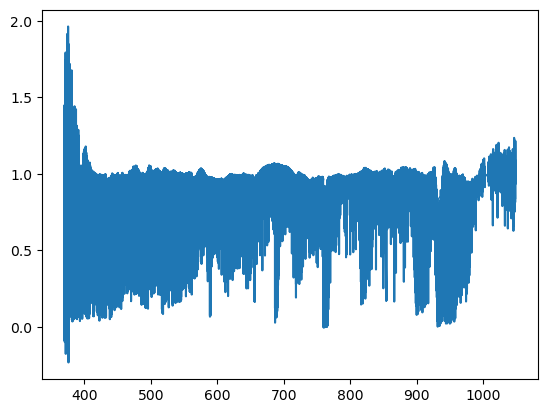

In [44]:
import matplotlib.pyplot as plt
plt.plot(hdul[1].data['AWAV'], hdul[1].data['FLUX_NOR'])